# Neural Nets with Keras

In this notebook you will learn how to implement neural networks using the Keras API. We will use TensorFlow's own implementation, *tf.keras*, which comes bundled with TensorFlow.

Don't hesitate to look at the documentation at [keras.io](https://keras.io/). All the code examples should work fine with tf.keras, the only difference is how to import Keras:

```python
# keras.io code:
from keras.layers import Dense
output_layer = Dense(10)

# corresponding tf.keras code:
from tensorflow.keras.layers import Dense
output_layer = Dense(10)

# or:
from tensorflow import keras
output_layer = keras.layers.Dense(10)
```

In this notebook, we will not use any TensorFlow-specific code, so everything you see would run just the same way on [keras-team](https://github.com/keras-team/keras) or any other Python implementation of the Keras API (except for the imports).

## Imports

In [1]:
%matplotlib inline
%load_ext tensorboard

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

In [ ]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [ ]:
print('GPU (optional):', tf.test.is_gpu_available())

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 1 – TensorFlow Playground

Visit the [TensorFlow Playground](http://playground.tensorflow.org).
* **Layers and patterns**: try training the default neural network by clicking the "Run" button (top left). Notice how it quickly finds a good solution for the classification task. Notice that the neurons in the first hidden layer have learned simple patterns, while the neurons in the second hidden layer have learned to combine the simple patterns of the first hidden layer into more complex patterns). In general, the more layers, the more complex the patterns can be.
* **Activation function**: try replacing the Tanh activation function with the ReLU activation function, and train the network again. Notice that it finds a solution even faster, but this time the boundaries are linear. This is due to the shape of the ReLU function.
* **Local minima**: modify the network architecture to have just one hidden layer with three neurons. Train it multiple times (to reset the network weights, just add and remove a neuron). Notice that the training time varies a lot, and sometimes it even gets stuck in a local minimum.
* **Too small**: now remove one neuron to keep just 2. Notice that the neural network is now incapable of finding a good solution, even if you try multiple times. The model has too few parameters and it systematically underfits the training set.
* **Large enough**: next, set the number of neurons to 8 and train the network several times. Notice that it is now consistently fast and never gets stuck. This highlights an important finding in neural network theory: large neural networks almost never get stuck in local minima, and even when they do these local optima are almost as good as the global optimum. However, they can still get stuck on long plateaus for a long time.
* **Deep net and vanishing gradients**: now change the dataset to be the spiral (bottom right dataset under "DATA"). Change the network architecture to have 4 hidden layers with 8 neurons each. Notice that training takes much longer, and often gets stuck on plateaus for long periods of time. Also notice that the neurons in the highest layers (i.e. on the right) tend to evolve faster than the neurons in the lowest layers (i.e. on the left). This problem, called the "vanishing gradients" problem, can be alleviated using better weight initialization and other techniques, better optimizers (such as AdaGrad or Adam), or using Batch Normalization.
* **More**: go ahead and play with the other parameters to get a feel of what they do. In fact, after this course you should definitely play with this UI for at least one hour, it will grow your intuitions about neural networks significantly.

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 2 – Image classification with tf.keras

### Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data())
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4423680/4422102 [==============================] - 2s 1us/step


The training set contains 55,000 grayscale images, each 28x28 pixels:

In [6]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented by a uint8 (byte) from 0 to 255:

In [7]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  44, 127,
        182, 185, 161, 120,  55,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 198, 251, 255,
        251, 249, 247, 255, 252, 214, 100,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   0, 233, 252, 237, 239,
        234, 237, 235, 237, 237, 254, 227,   0,   0,   0,   0,   1,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,  16, 210, 225, 215, 175,
        217, 216, 193, 196, 226, 221, 209,  50,   0,   0,   2,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   2,   0,   0, 199, 229, 232, 230, 245, 204,
        219, 253, 245, 207, 194, 223, 231, 236, 235,   0,   0,   3,   0,
          0,   0],
       [  

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

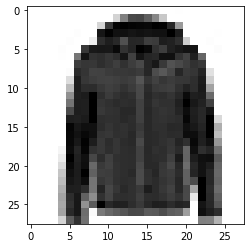

In [8]:
plt.imshow(X_train[0], cmap="binary")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [9]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [11]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [12]:
X_valid.shape

(5000, 28, 28)

In [13]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

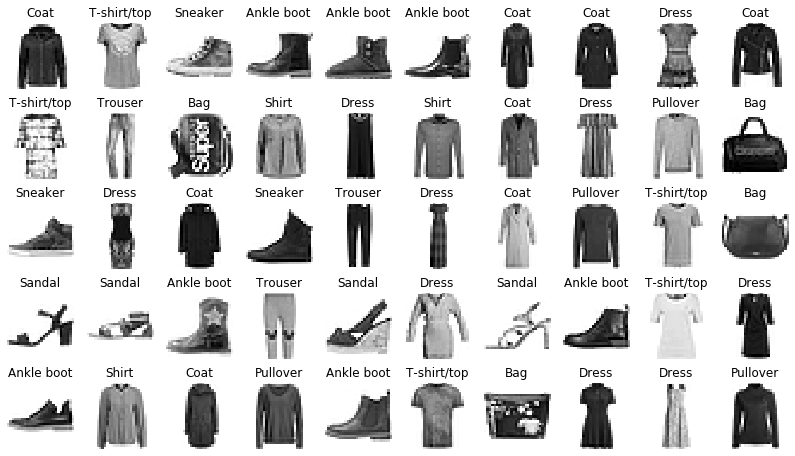

In [16]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

This dataset has the same structure as the famous MNIST dataset (which you can load using `keras.datasets.mnist.load_data()`), except the images represent fashion items rather than handwritten digits, and it is much more challenging. A simple linear model can reach 92% accuracy on MNIST, but only 83% on fashion MNIST.

### Build a classification neural network with Keras

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [74]:
model = keras.models.Sequential(name="mymodel")
model.add(keras.layers.Flatten(input_shape=[28,28], name="flatten_layer"))
model.add(keras.layers.Dense(300, activation="relu", name="dense_layer_1"))
model.add(keras.layers.Dense(100, activation="relu", name="dense_layer_2"))
model.add(keras.layers.Dense(10, activation="softmax", name="output_layer"))


### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [22]:
model2 = keras.models.Sequential(
    layers = [
    keras.layers.Flatten(input_shape=(28, 28)), 
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
], name = "mymodel2")

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

**Warning**: you will need `pydot` and `graphviz` to use `plot_model()`.

In [33]:
model.summary()

Model: "mymodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_layer (Flatten)      (None, 784)               0         
_________________________________________________________________
dense_layer_1 (Dense)        (None, 300)               235500    
_________________________________________________________________
dense_layer_2 (Dense)        (None, 100)               30100     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


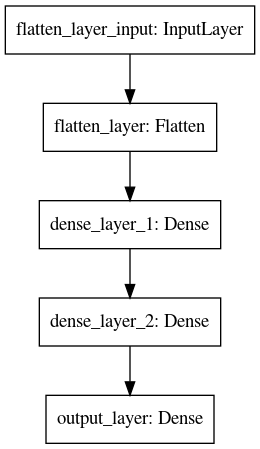

In [71]:
keras.utils.plot_model(model=model)

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `keras.optimizers.SGD(lr=1e-3)` optimizer (stochastic gradient descent with a learning rate of 1e-3). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [75]:
model.compile(optimizer=keras.optimizers.SGD(lr=1e-4), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [76]:
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 3s 57us/sample - loss: 9.7403 - accuracy: 0.3839 - val_loss: 9.1716 - val_accuracy: 0.4224
Epoch 2/40
55000/55000 [==============================] - 3s 54us/sample - loss: 9.0730 - accuracy: 0.4298 - val_loss: 9.0617 - val_accuracy: 0.4304
Epoch 3/40
55000/55000 [==============================] - 3s 54us/sample - loss: 8.9678 - accuracy: 0.4372 - val_loss: 9.0211 - val_accuracy: 0.4314
Epoch 4/40
55000/55000 [==============================] - 3s 55us/sample - loss: 8.8959 - accuracy: 0.4415 - val_loss: 8.9629 - val_accuracy: 0.4346
Epoch 5/40
55000/55000 [==============================] - 3s 56us/sample - loss: 8.8466 - accuracy: 0.4450 - val_loss: 8.9356 - val_accuracy: 0.4392
Epoch 6/40
55000/55000 [==============================] - 3s 54us/sample - loss: 8.7998 - accuracy: 0.4479 - val_loss: 9.0041 - val_accuracy: 0.4342
Epoch 7/40
55000/55000 [==============================] -

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

(0, 1)

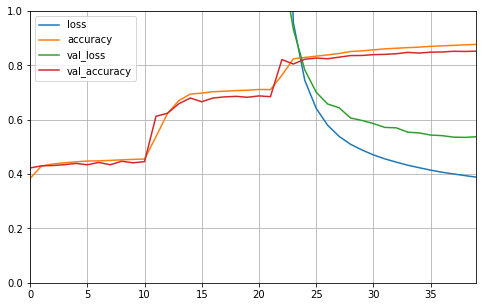

In [77]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [78]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.3827 - accuracy: 0.8790 - val_loss: 0.5249 - val_accuracy: 0.8526
Epoch 2/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.3777 - accuracy: 0.8789 - val_loss: 0.5254 - val_accuracy: 0.8536
Epoch 3/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.3733 - accuracy: 0.8798 - val_loss: 0.5246 - val_accuracy: 0.8578
Epoch 4/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.3686 - accuracy: 0.8828 - val_loss: 0.5219 - val_accuracy: 0.8552
Epoch 5/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.3646 - accuracy: 0.8840 - val_loss: 0.5232 - val_accuracy: 0.8534
Epoch 6/10
55000/55000 [==============================] - 3s 56us/sample - loss: 0.3612 - accuracy: 0.8848 - val_loss: 0.5224 - val_accuracy: 0.8566
Epoch 7/10
55000/55000 [==============================] -

### 2.8)
call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [79]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 30us/sample - loss: 0.5697 - accuracy: 0.8447


[0.569737444281578, 0.8447]

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [82]:
X_new = X_test[:5, :]
y_pred_proba_new = model.predict(X_new).round(3)

In [83]:
y_pred_proba_new

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.005, 0.   ,
        0.995],
       [0.001, 0.   , 0.947, 0.   , 0.001, 0.   , 0.052, 0.   , 0.   ,
        0.   ],
       [0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.061, 0.   , 0.039, 0.003, 0.025, 0.   , 0.871, 0.   , 0.   ,
        0.   ]], dtype=float32)

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [84]:
np.argmax(y_pred_proba_new, axis = 1)

array([9, 2, 1, 1, 6])

### 2.11)
Call the model's `predict_classes()` method for `X_new`. You should get the same result as above.

In [85]:
model.predict_classes(X_new)

array([9, 2, 1, 1, 6])

### 2.12)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [86]:
np.max(y_pred_proba_new, axis = 1)

array([0.995, 0.947, 1.   , 1.   , 0.871], dtype=float32)

### 2.13)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [99]:
k = 3
topk = np.argsort(-y_pred_proba_new, axis = 1)[:, :k]
topk

array([[9, 7, 0],
       [2, 6, 0],
       [1, 0, 2],
       [1, 0, 2],
       [6, 0, 2]])

In [98]:
row_indices = np.tile(np.arange(len(topk)), [k, 1]).T
y_pred_proba_new[row_indices, topk].round(2)

array([[1.  , 0.  , 0.  ],
       [0.95, 0.05, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.87, 0.06, 0.04]], dtype=float32)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 2 - Solution

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [87]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [88]:
model.layers

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

In [89]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_14 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


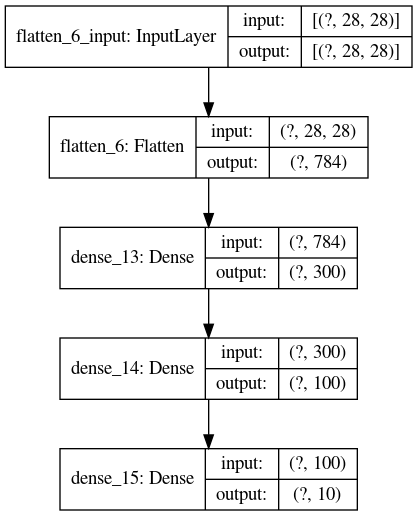

In [90]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

**Warning**: at the present, you need `from tensorflow.python.keras.utils.vis_utils import model_to_dot`, instead of simply `keras.utils.model_to_dot`. See [TensorFlow issue 24639](https://github.com/tensorflow/tensorflow/issues/24639).

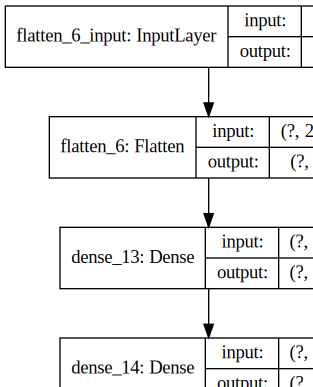

In [91]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `keras.optimizers.SGD(lr=1e-3)` optimizer (stochastic gradient descent with learning rate of 1e-3). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [92]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

In [104]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [ ]:
plot_learning_curves(history)

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

### 2.8)
Call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [ ]:
model.evaluate(X_test, y_test)

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [ ]:
n_new = 10
X_new = X_test[:n_new]
y_proba = model.predict(X_new)
y_proba.round(2)

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [ ]:
y_pred = y_proba.argmax(axis=1)
y_pred

### 2.11)
Call the model's `predict_classes()` method for `X_new`. You should get the same result as above.

In [ ]:
y_pred = model.predict_classes(X_new)
y_pred

### 2.12)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [ ]:
y_proba.max(axis=1).round(2)

### 2.13)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [ ]:
k = 3
top_k = np.argsort(-y_proba, axis=1)[:, :k]
top_k

In [ ]:
row_indices = np.tile(np.arange(len(top_k)), [k, 1]).T
y_proba[row_indices, top_k].round(2)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 3 – Scale the features

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

**Tips**:
* For each feature (pixel intensity), you must subtract the `mean()` of that feature (across all instances, so use `axis=0`) and divide by its standard deviation (`std()`, again `axis=0`). Alternatively, you can use Scikit-Learn's `StandardScaler`.
* Make sure you compute the means and standard deviations on the training set, and use these statistics to scale the training set, the validation set and the test set (you should not fit the validation set or the test set, and computing the means and standard deviations counts as "fitting").

### 3.2)
Plot the learning curves. Do they look better than earlier?

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 3 – Solution

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

In [100]:
pixel_means = X_train.mean(axis = 0)
pixel_stds = X_train.std(axis = 0)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

In [102]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 59us/sample - loss: 0.9373 - accuracy: 0.6893 - val_loss: 0.6369 - val_accuracy: 0.7756
Epoch 2/20
55000/55000 [==============================] - 3s 55us/sample - loss: 0.5836 - accuracy: 0.7938 - val_loss: 0.5317 - val_accuracy: 0.8092
Epoch 3/20
55000/55000 [==============================] - 3s 56us/sample - loss: 0.5097 - accuracy: 0.8203 - val_loss: 0.4838 - val_accuracy: 0.8270
Epoch 4/20
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4698 - accuracy: 0.8343 - val_loss: 0.4554 - val_accuracy: 0.8380
Epoch 5/20
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4433 - accuracy: 0.8431 - val_loss: 0.4358 - val_accuracy: 0.8476
Epoch 6/20
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4240 - accuracy: 0.8499 - val_loss: 0.4207 - val_accuracy: 0.8528
Epoch 7/20
55000/55000 [==============================] -

In [103]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 0s 31us/sample - loss: 0.3894 - accuracy: 0.8617


[0.3893868810892105, 0.8617]

### 3.2)
Plot the learning curves. Do they look better than earlier?

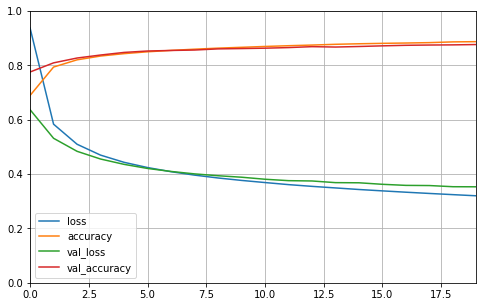

In [105]:
plot_learning_curves(history)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 4 – Use Callbacks

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [108]:
root_logdir = os.path.join(os.curdir, "my_logs")

### 4.2)
The Jupyter plugin for tensorboard was loaded at the beginning of this notebook (`%load_ext tensorboard`), so you can now simply start it by using the `%tensorboard` magic command. Explore the various tabs available, in particular the SCALARS tab to view learning curves, the GRAPHS tab to view the computation graph, and the PROFILE tab which is very useful to identify bottlenecks if you run into performance issues.

In [ ]:
%tensorboard --logdir=./my_logs

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 4 – Solution

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [106]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])

In [109]:
logdir = os.path.join(root_logdir, "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]
history = model.fit(X_train_scaled, y_train, epochs=50,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 3s 58us/sample - loss: 0.9723 - accuracy: 0.6867 - val_loss: 0.6322 - val_accuracy: 0.7882
Epoch 2/50
55000/55000 [==============================] - 3s 57us/sample - loss: 0.5845 - accuracy: 0.7981 - val_loss: 0.5264 - val_accuracy: 0.8198
Epoch 3/50
55000/55000 [==============================] - 3s 55us/sample - loss: 0.5079 - accuracy: 0.8222 - val_loss: 0.4797 - val_accuracy: 0.8382
Epoch 4/50
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4673 - accuracy: 0.8353 - val_loss: 0.4531 - val_accuracy: 0.8470
Epoch 5/50
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4409 - accuracy: 0.8444 - val_loss: 0.4332 - val_accuracy: 0.8530
Epoch 6/50
55000/55000 [==============================] - 3s 56us/sample - loss: 0.4212 - accuracy: 0.8504 - val_loss: 0.4211 - val_accuracy: 0.8556
Epoch 7/50
55000/55000 [==============================] -

### 4.2)
Done

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [110]:
model = keras.models.load_model("my_mnist_model.h5")

In [111]:
model.evaluate(X_valid_scaled, y_valid)

5000/5000 [==============================] - 0s 37us/sample - loss: 0.3248 - accuracy: 0.8896


[0.32479714453220365, 0.8896]

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 5 – A neural net for regression

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

**Tips**:
* Since you are predicting a single value per district (the median house price), there should only be one neuron in the output layer.
* Usually for regression tasks you don't want to use any activation function in the output layer (in some cases you may want to use `"relu"` or `"softplus"` if you want to constrain the predicted values to be positive, or `"sigmoid"` or `"tanh"` if you want to constrain the predicted values to 0-1 or -1-1).
* A good loss function for regression is generally the `"mean_squared_error"` (aka `"mse"`). When there are many outliers in your dataset, you may prefer to use the `"mean_absolute_error"` (aka `"mae"`), which is a bit less precise but less sensitive to outliers.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 5 – Solution

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [112]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

I0623 21:21:15.703314 139926126585664 california_housing.py:114] Downloading Cal. housing from https://ndownloader.figshare.com/files/5976036 to /home/yang/scikit_learn_data


In [113]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [114]:
housing.data.shape

(20640, 8)

In [115]:
housing.target.shape

(20640,)

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [116]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [117]:
len(X_train), len(X_valid), len(X_test)

(11610, 3870, 5160)

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [118]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

In [119]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [120]:
callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_valid_scaled, y_valid), epochs=100,
                    callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 32us/sample - loss: 2.6923 - val_loss: 1.6454
Epoch 2/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.9018 - val_loss: 1.0532
Epoch 3/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.7265 - val_loss: 0.6443
Epoch 4/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.6650 - val_loss: 0.8636
Epoch 5/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.6366 - val_loss: 0.9239
Epoch 6/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.6059 - val_loss: 0.7272
Epoch 7/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5871 - val_loss: 0.5709
Epoch 8/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5640 - val_loss: 0.5213
Epoch 9/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.546

Epoch 76/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3750 - val_loss: 0.3551
Epoch 77/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.3743 - val_loss: 0.3530
Epoch 78/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3737 - val_loss: 0.3676
Epoch 79/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.3734 - val_loss: 0.3663
Epoch 80/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3729 - val_loss: 0.3586
Epoch 81/100
11610/11610 [==============================] - 0s 23us/sample - loss: 0.3723 - val_loss: 0.3511
Epoch 82/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3719 - val_loss: 0.3506
Epoch 83/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.3713 - val_loss: 0.3616
Epoch 84/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3709 - val_loss: 0.3477
Epoch 85/100
11610/

In [121]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 12us/sample - loss: 0.3642


0.3641535673030587

In [122]:
model.predict(X_test_scaled)

array([[0.78247166],
       [1.5826169 ],
       [3.9552414 ],
       ...,
       [1.3169173 ],
       [2.248732  ],
       [3.9644845 ]], dtype=float32)

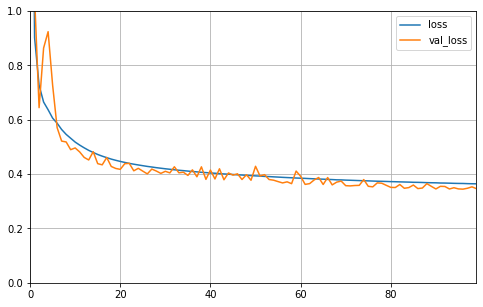

In [123]:
plot_learning_curves(history)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 6 – Hyperparameter search

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

**Tips**:
* create a `param_distribs` dictionary where each key is the name of a hyperparameter you want to fine-tune (e.g., `"n_hidden"`), and each value is the list of values you want to explore (e.g., `[0, 1, 2, 3]`), or a Scipy distribution from `scipy.stats`.
* You can use the reciprocal distribution for the learning rate (e.g, `reciprocal(3e-3, 3e-2)`).
* Create a `RandomizedSearchCV`, passing the `KerasRegressor` and the `param_distribs` to its constructor, as well as the number of iterations (`n_iter`), and the number of cross-validation folds (`cv`). If you are short on time, you can set `n_iter=10` and `cv=3`. You may also want to set `verbose=2`.
* Finally, call the `RandomizedSearchCV`'s `fit()` method on the training set. Once again you can pass it `n_epochs`, `validation_data` and `callbacks` if you want to.
* The best parameters found will be available in the `best_params_` attribute, the best score will be in `best_score_`, and the best model will be in `best_estimator_`.

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

**Tip**: while a randomized search is nice and simple, there are more powerful (but complex) options available out there for hyperparameter search, for example:
* [Hyperopt](https://github.com/hyperopt/hyperopt)
* [Hyperas](https://github.com/maxpumperla/hyperas)
* [Sklearn-Deap](https://github.com/rsteca/sklearn-deap)
* [Scikit-Optimize](https://scikit-optimize.github.io/)
* [Spearmint](https://github.com/JasperSnoek/spearmint)
* [PyMC3](https://docs.pymc.io/)
* [GPFlow](https://gpflow.readthedocs.io/)
* [Yelp/MOE](https://github.com/Yelp/MOE)
* Commercial services such as: [Google Cloud ML Engine](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning), [Arimo](https://arimo.com/) or [Oscar](http://oscar.calldesk.ai/)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 6 – Solution

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [124]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_valid_scaled, y_valid), epochs=100,
                        callbacks=callbacks)
    histories.append(history)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 32us/sample - loss: 6.0067 - val_loss: 6.3316
Epoch 2/100
11610/11610 [==============================] - 0s 25us/sample - loss: 4.0407 - val_loss: 3.5656
Epoch 3/100
11610/11610 [==============================] - 0s 25us/sample - loss: 2.8559 - val_loss: 2.3796
Epoch 4/100
11610/11610 [==============================] - 0s 26us/sample - loss: 2.1188 - val_loss: 1.8649
Epoch 5/100
11610/11610 [==============================] - 0s 25us/sample - loss: 1.6506 - val_loss: 1.6120
Epoch 6/100
11610/11610 [==============================] - 0s 25us/sample - loss: 1.3476 - val_loss: 1.4488
Epoch 7/100
11610/11610 [==============================] - 0s 25us/sample - loss: 1.1480 - val_loss: 1.3106
Epoch 8/100
11610/11610 [==============================] - 0s 25us/sample - loss: 1.0129 - val_loss: 1.1834
Epoch 9/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.919

Epoch 76/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4744 - val_loss: 0.4455
Epoch 77/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4731 - val_loss: 0.4440
Epoch 78/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4718 - val_loss: 0.4426
Epoch 79/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4706 - val_loss: 0.4413
Epoch 80/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4694 - val_loss: 0.4400
Epoch 81/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4683 - val_loss: 0.4387
Epoch 82/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4671 - val_loss: 0.4375
Epoch 83/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4660 - val_loss: 0.4364
Epoch 84/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4649 - val_loss: 0.4353
Epoch 85/100
11610/

Epoch 51/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4333 - val_loss: 0.4229
Epoch 52/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4323 - val_loss: 0.4219
Epoch 53/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4312 - val_loss: 0.4224
Epoch 54/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4302 - val_loss: 0.4244
Epoch 55/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4292 - val_loss: 0.4247
Epoch 56/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4282 - val_loss: 0.4260
Epoch 57/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4272 - val_loss: 0.4257
Epoch 58/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4263 - val_loss: 0.4229
Epoch 59/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4254 - val_loss: 0.4200
Epoch 60/100
11610/

Epoch 26/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4104 - val_loss: 0.4146
Epoch 27/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4088 - val_loss: 0.4023
Epoch 28/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4071 - val_loss: 0.4356
Epoch 29/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4056 - val_loss: 0.4018
Epoch 30/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4046 - val_loss: 0.4039
Epoch 31/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4032 - val_loss: 0.4360
Epoch 32/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4020 - val_loss: 0.4357
Epoch 33/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4011 - val_loss: 0.4416
Epoch 34/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4000 - val_loss: 0.4064
Epoch 35/100
11610/

Epoch 10/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.3702 - val_loss: 0.3348
Epoch 11/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3605 - val_loss: 0.3318
Epoch 12/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.3970 - val_loss: 0.3365
Epoch 13/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3620 - val_loss: 0.3375
Epoch 14/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.3560 - val_loss: 0.3324
Epoch 15/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3512 - val_loss: 0.3327
Epoch 16/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3482 - val_loss: 0.3252
Epoch 17/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3453 - val_loss: 0.3431
Epoch 18/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.3434 - val_loss: 0.3245
Epoch 19/100
11610/

Learning rate: 0.0001


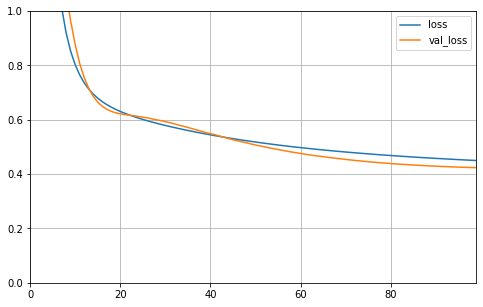

Learning rate: 0.0003


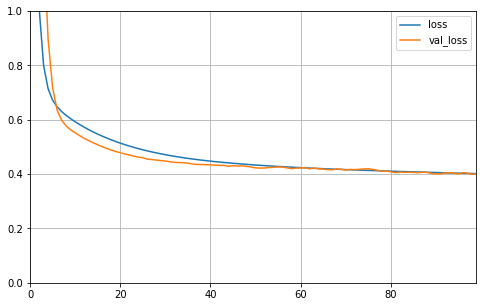

Learning rate: 0.001


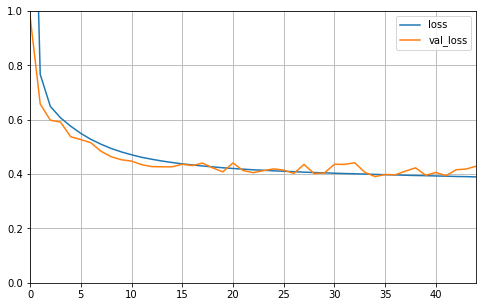

Learning rate: 0.003


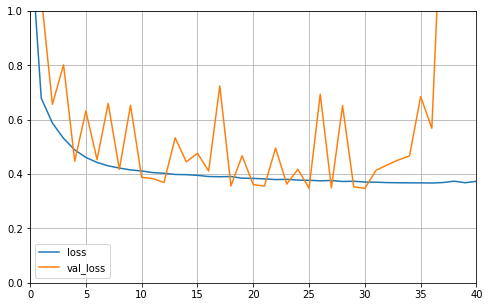

Learning rate: 0.01


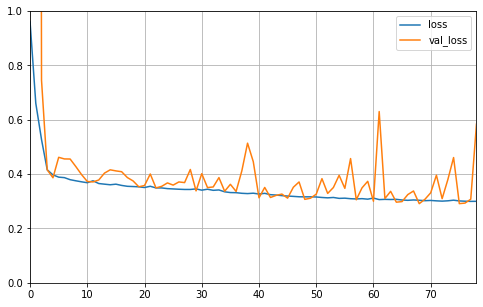

Learning rate: 0.03


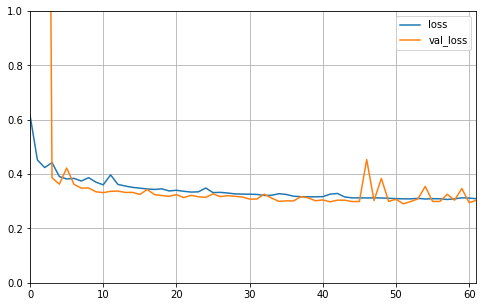

In [125]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_curves(history)

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [126]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    options = {"input_shape": X_train.shape[1:]}
    for layer in range(n_hidden + 1):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [127]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [128]:
keras_reg.fit(X_train_scaled, y_train, epochs=100,
              validation_data=(X_valid_scaled, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.8625 - val_loss: 4.9468
Epoch 2/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5869 - val_loss: 2.8155
Epoch 3/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5051 - val_loss: 0.7310
Epoch 4/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4557 - val_loss: 0.4712
Epoch 5/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4302 - val_loss: 0.3938
Epoch 6/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4138 - val_loss: 0.4067
Epoch 7/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4023 - val_loss: 0.3769
Epoch 8/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3938 - val_loss: 0.3808
Epoch 9/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.386

In [129]:
keras_reg.predict(X_test_scaled)

array([0.6382514, 1.4696546, 4.5765114, ..., 1.5380781, 2.2808766,
       4.351279 ], dtype=float32)

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

In [130]:
from scipy.stats import reciprocal

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

In [131]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

In [132]:
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.00042581884041882227, n_hidden=1, n_neurons=66 ..
Train on 7740 samples, validate on 3870 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7740/7740 [==============================] - 0s 43us/sample - loss: 3.4325 - val_loss: 3.3201
Epoch 2/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.6103 - val_loss: 2.5421
Epoch 3/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.0814 - val_loss: 1.1272
Epoch 4/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.8513 - val_loss: 0.7751
Epoch 5/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.7450 - val_loss: 0.7119
Epoch 6/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6942 - val_loss: 0.6647
Epoch 7/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6650 - val_loss: 0.6357
Epoch 8/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6440 - val_loss: 0.6261
Epoch 9/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6279 - val_loss: 0.5969
Epoch 10/100
7740/7740 [==============================] - 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s


Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 44us/sample - loss: 3.2350 - val_loss: 8.2660
Epoch 2/100
7740/7740 [==============================] - 0s 36us/sample - loss: 1.5487 - val_loss: 11.6793
Epoch 3/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.0756 - val_loss: 11.8445
Epoch 4/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.8814 - val_loss: 10.0733
Epoch 5/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7848 - val_loss: 8.4519
Epoch 6/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.7321 - val_loss: 6.9898
Epoch 7/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6993 - val_loss: 5.8109
Epoch 8/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6763 - val_loss: 4.6877
Epoch 9/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.6577 - val_loss: 3.

3870/3870 [==============================] - 0s 11us/sample - loss: 0.3081
[CV]  learning_rate=0.01598323325710045, n_hidden=3, n_neurons=69, total=   9.8s
[CV] learning_rate=0.01598323325710045, n_hidden=3, n_neurons=69 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.7017 - val_loss: 0.5375
Epoch 2/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4016 - val_loss: 0.6612
Epoch 3/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3850 - val_loss: 0.8089
Epoch 4/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3629 - val_loss: 1.1132
Epoch 5/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3471 - val_loss: 1.1121
Epoch 6/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3428 - val_loss: 0.8861
Epoch 7/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3370 - 

7740/7740 [==============================] - 0s 32us/sample - loss: 0.3087 - val_loss: 0.3053
Epoch 69/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3085 - val_loss: 0.3093
Epoch 70/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3081 - val_loss: 0.3034
Epoch 71/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3078 - val_loss: 0.3159
Epoch 72/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3090 - val_loss: 0.3105
Epoch 73/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3074 - val_loss: 0.3026
Epoch 74/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3077 - val_loss: 0.3111
Epoch 75/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3066 - val_loss: 0.3102
Epoch 76/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3057 - val_loss: 0.3049
Epoch 77/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 31us/sample - loss: 0.3745 - val_loss: 0.4891
Epoch 13/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.3704 - val_loss: 0.5959
Epoch 14/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3665 - val_loss: 0.7534
Epoch 15/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3635 - val_loss: 0.8233
Epoch 16/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3611 - val_loss: 0.9227
Epoch 17/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.3589 - val_loss: 0.9938
Epoch 18/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3563 - val_loss: 1.0610
Epoch 19/100
3870/3870 [==============================] - 0s 11us/sample - loss: 0.3734
[CV]  learning_rate=0.002682820301643939, n_hidden=1, n_neurons=84, total=   4.8s
[CV] learning_rate=0.002682820301643939, n_hidden=1, n_neurons=84 ....
Train on 7740 samples, 

7740/7740 [==============================] - 0s 32us/sample - loss: 0.3181 - val_loss: 0.3128
Epoch 25/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3144 - val_loss: 0.3172
Epoch 26/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3127 - val_loss: 0.3752
Epoch 27/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3121 - val_loss: 0.3231
Epoch 28/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3090 - val_loss: 0.3179
Epoch 29/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3062 - val_loss: 0.5925
Epoch 30/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3103 - val_loss: 0.3840
Epoch 31/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3062 - val_loss: 0.3931
Epoch 32/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3017 - val_loss: 0.3450
Epoch 33/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 26us/sample - loss: 0.5346 - val_loss: 0.4967
Epoch 16/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5247 - val_loss: 0.4893
Epoch 17/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5147 - val_loss: 0.4791
Epoch 18/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5071 - val_loss: 0.4797
Epoch 19/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4988 - val_loss: 0.4725
Epoch 20/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4922 - val_loss: 0.4605
Epoch 21/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4856 - val_loss: 0.4594
Epoch 22/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4802 - val_loss: 0.4554
Epoch 23/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4752 - val_loss: 0.4556
Epoch 24/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 27us/sample - loss: 0.3296 - val_loss: 0.3324
Epoch 66/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3301 - val_loss: 0.3277
Epoch 67/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3309 - val_loss: 0.3234
Epoch 68/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3282 - val_loss: 0.3283
Epoch 69/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3277 - val_loss: 0.3399
Epoch 70/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3274 - val_loss: 0.3398
Epoch 71/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3266 - val_loss: 0.3237
Epoch 72/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3255 - val_loss: 0.3231
Epoch 73/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3252 - val_loss: 0.3212
Epoch 74/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 28us/sample - loss: 0.3355 - val_loss: 0.3398
Epoch 32/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3338 - val_loss: 0.3403
Epoch 33/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3327 - val_loss: 0.3617
Epoch 34/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3330 - val_loss: 0.3556
Epoch 35/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3331 - val_loss: 0.3684
Epoch 36/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3420 - val_loss: 0.3383
Epoch 37/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3293 - val_loss: 0.3427
Epoch 38/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3274 - val_loss: 0.3252
Epoch 39/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3258 - val_loss: 0.3309
Epoch 40/100
7740/7740 [==========================

3870/3870 [==============================] - 0s 11us/sample - loss: 0.5169
[CV]  learning_rate=0.00040257514452906034, n_hidden=1, n_neurons=78, total=   6.4s
[CV] learning_rate=0.00040257514452906034, n_hidden=1, n_neurons=78 ..
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 48us/sample - loss: 3.3689 - val_loss: 5.1754
Epoch 2/100
7740/7740 [==============================] - 0s 39us/sample - loss: 1.5320 - val_loss: 2.6173
Epoch 3/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.9900 - val_loss: 1.1796
Epoch 4/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.8002 - val_loss: 0.7859
Epoch 5/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7234 - val_loss: 0.6894
Epoch 6/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6859 - val_loss: 0.6557
Epoch 7/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6618

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.4min finished


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5925 - val_loss: 1.0424
Epoch 2/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3825 - val_loss: 0.4793
Epoch 3/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.3620 - val_loss: 0.5787
Epoch 4/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3508 - val_loss: 1.9250
Epoch 5/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3460 - val_loss: 0.3215
Epoch 6/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3296 - val_loss: 0.4382
Epoch 7/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3219 - val_loss: 0.3328
Epoch 8/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3173 - val_loss: 0.3238
Epoch 9/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.310

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f42123b0908>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f421209acc0>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_trai

In [133]:
rnd_search_cv.best_params_

{'learning_rate': 0.01598323325710045, 'n_hidden': 3, 'n_neurons': 69}

In [134]:
rnd_search_cv.best_score_

-0.3003794024773038

In [136]:
rnd_search_cv.best_estimator_

In [138]:
pd.DataFrame(rnd_search_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_hidden,param_n_neurons,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,13.949006,4.536095,0.050864,0.007241,0.000425819,1,66,"{'learning_rate': 0.00042581884041882227, 'n_h...",-0.406112,-0.447966,-0.377156,-0.410411,0.029067,7
1,10.436013,1.815878,0.046164,0.001493,0.0159832,3,69,"{'learning_rate': 0.01598323325710045, 'n_hidd...",-0.308132,-0.304943,-0.288063,-0.300379,0.008806,1
2,14.114502,6.567680,0.044076,0.001005,0.00549799,3,9,"{'learning_rate': 0.00549798946057251, 'n_hidd...",-0.346643,-0.385310,-0.357252,-0.363069,0.016312,5
3,9.014595,4.923662,0.045919,0.005443,0.00268282,1,84,"{'learning_rate': 0.002682820301643939, 'n_hid...",-0.365997,-0.373376,-0.322559,-0.353978,0.022419,4
4,7.085973,2.659615,0.044124,0.002303,0.0074255,2,61,"{'learning_rate': 0.00742549569619473, 'n_hidd...",-0.328386,-0.357004,-0.311890,-0.332427,0.018638,2
5,16.027128,8.142243,0.035170,0.000683,0.000721554,0,36,"{'learning_rate': 0.0007215540228653338, 'n_hi...",-0.391386,-0.522256,-0.393650,-0.435764,0.061166,9
6,9.917963,7.982446,0.036353,0.000395,0.00653933,0,38,"{'learning_rate': 0.006539330094363484, 'n_hid...",-0.350325,-0.372767,-0.375131,-0.366074,0.011178,6
7,8.114430,5.750464,0.036842,0.001244,0.0110046,0,67,"{'learning_rate': 0.011004556623399147, 'n_hid...",-0.365798,-0.371278,-0.315779,-0.350952,0.024972,3
8,12.781952,5.527271,0.044550,0.000730,0.000402575,1,78,"{'learning_rate': 0.00040257514452906034, 'n_h...",-0.392737,-0.516950,-0.399296,-0.436328,0.057071,10
9,6.002672,2.094626,0.039490,0.000725,0.00152678,1,16,"{'learning_rate': 0.0015267755614319788, 'n_hi...",-0.404579,-0.511233,-0.384972,-0.433595,0.055479,8


### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

In [139]:
rnd_search_cv.score(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 19us/sample - loss: 0.2802


-0.28016440521839053

In [140]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 14us/sample - loss: 0.2802


0.28016440521839053

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

In [143]:
model.save("my_fine_tuned_housing_model.h5")

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 7 – The functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer, as shown on the following diagram:

<img src="images/wide_and_deep_net.png" title="Wide and deep net" width=300 />

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

**Tips**:
* You need to create a `keras.layers.Input` layer to represent the inputs. Don't forget to specify the input `shape`.
* Create the `Dense` layers, and connect them by using them like functions. For example, `hidden1 = keras.layers.Dense(30, activation="relu")(input)` and `hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)`
* Use the `keras.layers.concatenate()` function to concatenate the input layer and the second hidden layer's output.
* Create a `keras.models.Model` and specify its `inputs` and `outputs` (e.g., `inputs=[input]`).
* Then use this model just like a `Sequential` model: you need to compile it, display its summary, train it, evaluate it and use it to make predictions.

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

**When should you use the Subclassing API?**
* Both the Sequential API and the Functional API are declarative: you first declare the list of layers you need and how they are connected, and only then can you feed your model with actual data. The models that these APIs build are just static graphs of layers. This has many advantages (easy inspection, debugging, saving, loading, sharing, etc.), and they cover the vast majority of use cases, but if you need to build a very dynamic model (e.g., with loops or conditional branching), or if you want to experiment with new ideas using an imperative programming style, then the Subclassing API is for you. You can pretty much do any computation you want in the `call()` method, possibly with loops and conditions, using Keras layers of even low-level TensorFlow operations.
* However, this extra flexibility comes at the cost of less transparency. Since the model is defined within the `call()` method, Keras cannot fully inspect it. All it sees is the list of model attributes (which include the layers you define in the constructor), so when you display the model summary you just see a list of unconnected layers. Consequently, you cannot save or load the model without writing extra code. So this API is best used only when you really need the extra flexibility.

In [ ]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # create layers here

    def call(self, input):
        # write any code here, using layers or even low-level TF code
        return output

model = MyModel()

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the following diagram. Use the functional API to build, train and evaluate this model.

**Tips**:
* You need to create two `keras.layers.Input` (`input_A` and `input_B`)
* Build the model using the functional API, as above, but when you build the `keras.models.Model`, remember to set `inputs=[input_A, input_B]`
* When calling `fit()`, `evaluate()` and  `predict()`, instead of passing `X_train_scaled`, pass `(X_train_scaled_A, X_train_scaled_B)` (two NumPy arrays containing only the appropriate features copied from `X_train_scaled`).

<img src="images/multiple_inputs.png" title="Multiple inputs" width=300 />

### 7.4)
Build the multi-input and multi-output neural net represented in the following diagram.

<img src="images/multiple_inputs_and_outputs.png" title="Multiple inputs and outputs" width=400 />

**Why?**

There are many use cases in which having multiple outputs can be useful:
* Your task may require multiple outputs, for example, you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object's center, as well as its width and height) and a classification task.
* Similarly, you may have multiple independent tasks to perform based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks.
* Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model's ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture (as shown in the diagram) to ensure that that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

**Tips**:
* Building the model is pretty straightforward using the functional API. Just make sure you specify both outputs when creating the `keras.models.Model`, for example `outputs=[output, aux_output]`.
* Each output has its own loss function. In this scenario, they will be identical, so you can either specify `loss="mse"` (this loss will apply to both outputs) or `loss=["mse", "mse"]`, which does the same thing.
* The final loss used to train the whole network is just a weighted sum of all loss functions. In this scenario, you want most to give a much smaller weight to the auxiliary output, so when compiling the model, you must specify `loss_weights=[0.9, 0.1]`.
* When calling `fit()` or `evaluate()`, you need to pass the labels for all outputs. In this scenario the labels will be the same for the main output and for the auxiliary output, so make sure to pass `(y_train, y_train)` instead of `y_train`.
* The `predict()` method will return both the main output and the auxiliary output.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 7 – Solution

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

In [144]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

In [145]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [146]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [147]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_140 (Dense)               (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_141 (Dense)               (None, 30)           930         dense_140[0][0]                  
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_141[0][0]              

In [148]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 36us/sample - loss: 1.9821 - val_loss: 0.8489
Epoch 2/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.6627 - val_loss: 0.6167
Epoch 3/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5983 - val_loss: 0.5560
Epoch 4/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5646 - val_loss: 0.6290
Epoch 5/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5417 - val_loss: 0.5091
Epoch 6/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5205 - val_loss: 0.5081
Epoch 7/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5031 - val_loss: 0.4671
Epoch 8/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4890 - val_loss: 0.4577
Epoch 9/10
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4770 - val_l

In [149]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: 0.4561


0.45609413496283596

In [150]:
model.predict(X_test_scaled)

array([[0.61378306],
       [1.4851139 ],
       [3.2046404 ],
       ...,
       [1.325384  ],
       [2.5853205 ],
       [3.5058508 ]], dtype=float32)

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

In [151]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.hidden2 = keras.layers.Dense(30, activation="relu")
        self.output_ = keras.layers.Dense(1)

    def call(self, input):
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [152]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(1e-3))

In [153]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 36us/sample - loss: 2.4264 - val_loss: 1.6911
Epoch 2/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.6783 - val_loss: 0.6967
Epoch 3/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.6027 - val_loss: 0.5597
Epoch 4/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5662 - val_loss: 0.5269
Epoch 5/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5390 - val_loss: 0.5208
Epoch 6/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5164 - val_loss: 0.4961
Epoch 7/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4982 - val_loss: 0.4707
Epoch 8/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4822 - val_loss: 0.4759
Epoch 9/10
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4683 - val_l

In [154]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            multiple                  270       
_________________________________________________________________
dense_144 (Dense)            multiple                  930       
_________________________________________________________________
dense_145 (Dense)            multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [155]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 14us/sample - loss: 0.4416


0.4415814147439114

In [156]:
model.predict(X_test_scaled)

array([[0.6992489],
       [1.5901222],
       [3.1621583],
       ...,
       [1.3721452],
       [2.6269217],
       [3.4624581]], dtype=float32)

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the diagram. Use the functional API to build, train and evaluate this model.

In [157]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])

In [158]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)

In [159]:
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [160]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [161]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_146 (Dense)               (None, 30)           210         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_147 (Dense)               (None, 30)           930         dense_146[0][0]                  
____________________________________________________________________________________________

In [162]:
X_train_scaled_A = X_train_scaled[:, :5]
X_train_scaled_B = X_train_scaled[:, 2:]
X_valid_scaled_A = X_valid_scaled[:, :5]
X_valid_scaled_B = X_valid_scaled[:, 2:]
X_test_scaled_A = X_test_scaled[:, :5]
X_test_scaled_B = X_test_scaled[:, 2:]

In [163]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], y_train, epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 36us/sample - loss: 2.6337 - val_loss: 1.2723
Epoch 2/10
11610/11610 [==============================] - 0s 29us/sample - loss: 0.8020 - val_loss: 0.7134
Epoch 3/10
11610/11610 [==============================] - 0s 29us/sample - loss: 0.6420 - val_loss: 0.6406
Epoch 4/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5784 - val_loss: 0.5605
Epoch 5/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5403 - val_loss: 0.4962
Epoch 6/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5124 - val_loss: 0.4925
Epoch 7/10
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4924 - val_loss: 0.4581
Epoch 8/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4761 - val_loss: 0.4630
Epoch 9/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4647 - val_l

In [164]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test)

5160/5160 [==============================] - 0s 14us/sample - loss: 0.4399


0.43988039613694185

In [165]:
model.predict([X_test_scaled_A, X_test_scaled_B])

array([[0.5739323],
       [1.7475454],
       [3.0108223],
       ...,
       [1.2615273],
       [2.7169118],
       [3.5763674]], dtype=float32)

### 7.4)
Build the multi-input and multi-output neural net represented in the diagram.

In [166]:
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[1:])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)

In [167]:
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [168]:
model.compile(loss="mean_squared_error", loss_weights=[0.9, 0.1],
              optimizer=keras.optimizers.SGD(1e-3))

In [169]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_149 (Dense)               (None, 30)           210         input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_150 (Dense)               (None, 30)           930         dense_149[0][0]                  
____________________________________________________________________________________________

In [170]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], [y_train, y_train], epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 45us/sample - loss: 2.7503 - dense_151_loss: 2.4960 - dense_152_loss: 5.0299 - val_loss: 1.2045 - val_dense_151_loss: 0.8786 - val_dense_152_loss: 4.1352
Epoch 2/10
11610/11610 [==============================] - 0s 32us/sample - loss: 1.0121 - dense_151_loss: 0.7355 - dense_152_loss: 3.5006 - val_loss: 0.9107 - val_dense_151_loss: 0.6624 - val_dense_152_loss: 3.1436
Epoch 3/10
11610/11610 [==============================] - 0s 35us/sample - loss: 0.8090 - dense_151_loss: 0.6313 - dense_152_loss: 2.4068 - val_loss: 0.8379 - val_dense_151_loss: 0.5811 - val_dense_152_loss: 3.1469
Epoch 4/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.7142 - dense_151_loss: 0.5866 - dense_152_loss: 1.8632 - val_loss: 0.8100 - val_dense_151_loss: 0.5691 - val_dense_152_loss: 2.9752
Epoch 5/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6592 - d

In [171]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], [y_test, y_test])

5160/5160 [==============================] - 0s 21us/sample - loss: 0.5368 - dense_151_loss: 0.4686 - dense_152_loss: 1.1616


[0.536818421071814, 0.4686052, 1.1615832]

In [172]:
y_pred, y_pred_aux = model.predict([X_test_scaled_A, X_test_scaled_B])

In [173]:
y_pred

array([[0.44112694],
       [1.6795588 ],
       [3.097958  ],
       ...,
       [1.4666784 ],
       [2.57908   ],
       [3.4613328 ]], dtype=float32)

In [174]:
y_pred_aux

array([[1.2651714],
       [1.5779603],
       [2.1875467],
       ...,
       [1.5485897],
       [1.7406982],
       [2.09869  ]], dtype=float32)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 8 – Deep Nets

Let's go back to Fashion MNIST and build deep nets to tackle it. We need to load it, split it and scale it.

In [175]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [176]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead (always use SELU with LeCun Normal weight initialization). Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

**Warning**: you should not use regular Dropout, as it breaks the self-normalizing property of the SELU activation function. Instead, use AlphaDropout, which is designed to work with SELU.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 8 – Solution

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 99us/sample - loss: 2.3022 - accuracy: 0.1239 - val_loss: 2.3019 - val_accuracy: 0.1312
Epoch 2/10
55000/55000 [==============================] - 5s 95us/sample - loss: 2.3013 - accuracy: 0.1641 - val_loss: 2.3004 - val_accuracy: 0.1496
Epoch 3/10
55000/55000 [==============================] - 5s 95us/sample - loss: 2.2987 - accuracy: 0.1699 - val_loss: 2.2964 - val_accuracy: 0.1590
Epoch 4/10
55000/55000 [==============================] - 5s 95us/sample - loss: 2.2918 - accuracy: 0.1926 - val_loss: 2.2849 - val_accuracy: 0.2160
Epoch 5/10
55000/55000 [==============================] - 5s 96us/sample - loss: 2.2714 - accuracy: 0.2265 - val_loss: 2.2511 - val_accuracy: 0.2228
Epoch 6/10
55000/55000 [==============================] - 5s 95us/sample - loss: 2.2133 - accuracy: 0.2086 - val_loss: 2.1569 - val_accuracy: 0.2178
Epoch 7/10
55000/55000 [==============================] -

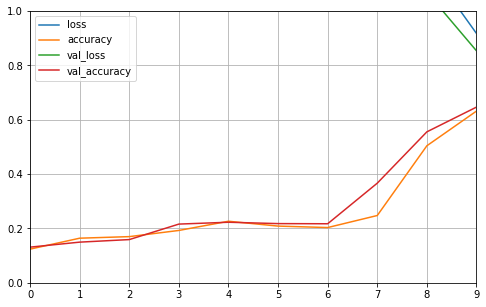

In [177]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 15s 266us/sample - loss: 1.9325 - accuracy: 0.3614 - val_loss: 1.0351 - val_accuracy: 0.6484
Epoch 2/10
55000/55000 [==============================] - 10s 185us/sample - loss: 1.0899 - accuracy: 0.6248 - val_loss: 0.7781 - val_accuracy: 0.7244
Epoch 3/10
55000/55000 [==============================] - 10s 176us/sample - loss: 0.9244 - accuracy: 0.6746 - val_loss: 0.6834 - val_accuracy: 0.7566
Epoch 4/10
55000/55000 [==============================] - 10s 177us/sample - loss: 0.8558 - accuracy: 0.6983 - val_loss: 0.6301 - val_accuracy: 0.7722
Epoch 5/10
55000/55000 [==============================] - 10s 183us/sample - loss: 0.8078 - accuracy: 0.7134 - val_loss: 0.6000 - val_accuracy: 0.7834
Epoch 6/10
55000/55000 [==============================] - 11s 192us/sample - loss: 0.7685 - accuracy: 0.7282 - val_loss: 0.5707 - val_accuracy: 0.7922
Epoch 7/10
55000/55000 [=====================

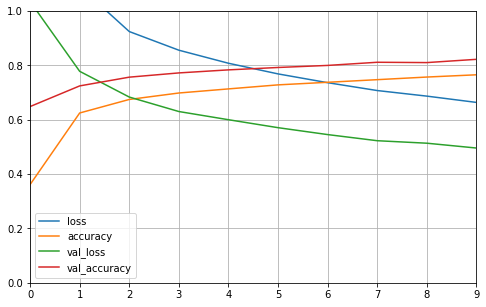

In [178]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [179]:
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_174 (Dense)            (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_175 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_176 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)             

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 14s 259us/sample - loss: 1.9844 - accuracy: 0.3062 - val_loss: 1.2572 - val_accuracy: 0.5876
Epoch 2/10
55000/55000 [==============================] - 11s 193us/sample - loss: 1.1700 - accuracy: 0.6105 - val_loss: 0.7946 - val_accuracy: 0.7264
Epoch 3/10
55000/55000 [==============================] - 11s 193us/sample - loss: 0.9478 - accuracy: 0.6802 - val_loss: 0.6849 - val_accuracy: 0.7614
Epoch 4/10
55000/55000 [==============================] - 11s 197us/sample - loss: 0.8552 - accuracy: 0.7084 - val_loss: 0.6376 - val_accuracy: 0.7766
Epoch 5/10
55000/55000 [==============================] - 11s 195us/sample - loss: 0.7986 - accuracy: 0.7268 - val_loss: 0.5947 - val_accuracy: 0.7898
Epoch 6/10
55000/55000 [==============================] - 11s 196us/sample - loss: 0.7497 - accuracy: 0.7415 - val_loss: 0.5630 - val_accuracy: 0.8016
Epoch 7/10
55000/55000 [=====================

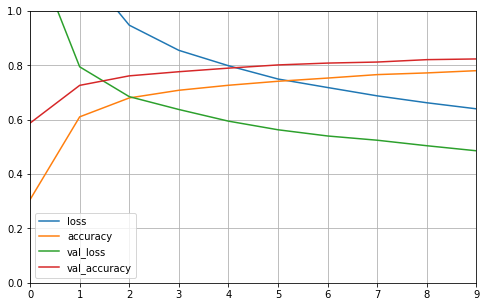

In [180]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead (always use SELU with LeCun Normal weight initialization). Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 139us/sample - loss: 0.6612 - accuracy: 0.7679 - val_loss: 0.4876 - val_accuracy: 0.8294
Epoch 2/10
55000/55000 [==============================] - 7s 128us/sample - loss: 0.4510 - accuracy: 0.8377 - val_loss: 0.4405 - val_accuracy: 0.8426
Epoch 3/10
55000/55000 [==============================] - 7s 128us/sample - loss: 0.3993 - accuracy: 0.8564 - val_loss: 0.3992 - val_accuracy: 0.8572
Epoch 4/10
55000/55000 [==============================] - 7s 128us/sample - loss: 0.3689 - accuracy: 0.8658 - val_loss: 0.3896 - val_accuracy: 0.8612
Epoch 5/10
55000/55000 [==============================] - 7s 128us/sample - loss: 0.3456 - accuracy: 0.8748 - val_loss: 0.3794 - val_accuracy: 0.8660
Epoch 6/10
55000/55000 [==============================] - 7s 128us/sample - loss: 0.3289 - accuracy: 0.8803 - val_loss: 0.3767 - val_accuracy: 0.8678
Epoch 7/10
55000/55000 [===========================

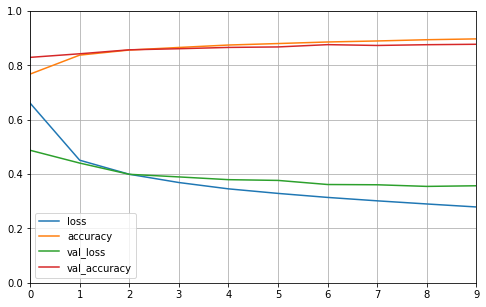

In [181]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 129us/sample - loss: 0.2697 - accuracy: 0.9009 - val_loss: 0.3601 - val_accuracy: 0.8742
Epoch 2/10
55000/55000 [==============================] - 7s 129us/sample - loss: 0.2602 - accuracy: 0.9048 - val_loss: 0.3526 - val_accuracy: 0.8782
Epoch 3/10
55000/55000 [==============================] - 7s 130us/sample - loss: 0.2526 - accuracy: 0.9074 - val_loss: 0.3537 - val_accuracy: 0.8776
Epoch 4/10
55000/55000 [==============================] - 7s 130us/sample - loss: 0.2447 - accuracy: 0.9098 - val_loss: 0.3509 - val_accuracy: 0.8810
Epoch 5/10
55000/55000 [==============================] - 7s 130us/sample - loss: 0.2373 - accuracy: 0.9136 - val_loss: 0.3511 - val_accuracy: 0.8792
Epoch 6/10
55000/55000 [==============================] - 7s 128us/sample - loss: 0.2298 - accuracy: 0.9163 - val_loss: 0.3586 - val_accuracy: 0.8756
Epoch 7/10
55000/55000 [===========================

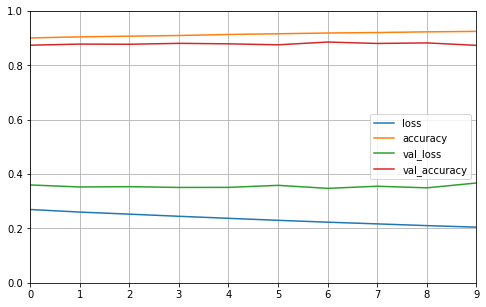

In [182]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 9s 159us/sample - loss: 1.1577 - accuracy: 0.6067 - val_loss: 0.7085 - val_accuracy: 0.8134
Epoch 2/20
55000/55000 [==============================] - 8s 138us/sample - loss: 0.6555 - accuracy: 0.7847 - val_loss: 0.6467 - val_accuracy: 0.8386
Epoch 3/20
55000/55000 [==============================] - 7s 134us/sample - loss: 0.5434 - accuracy: 0.8221 - val_loss: 0.6350 - val_accuracy: 0.8482
Epoch 4/20
55000/55000 [==============================] - 7s 134us/sample - loss: 0.4936 - accuracy: 0.8391 - val_loss: 0.6058 - val_accuracy: 0.8638
Epoch 5/20
55000/55000 [==============================] - 7s 131us/sample - loss: 0.4517 - accuracy: 0.8512 - val_loss: 0.5928 - val_accuracy: 0.8664
Epoch 6/20
55000/55000 [==============================] - 7s 121us/sample - loss: 0.4277 - accuracy: 0.8597 - val_loss: 0.5626 - val_accuracy: 0.8720
Epoch 7/20
55000/55000 [===========================

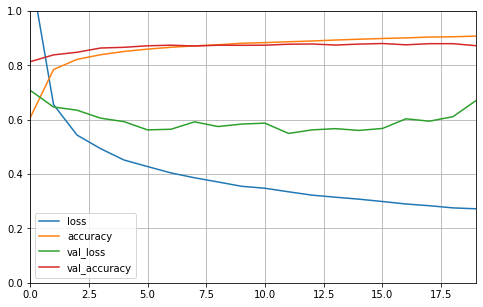

In [183]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)